### 기존 버전 첫 테스트

In [2]:
from pathlib import Path
import sys

root = Path.cwd()
while not (root / "utils").exists() and root != root.parent:
    root = root.parent
sys.path.insert(0, str(root))

from utils.main3 import run_langraph

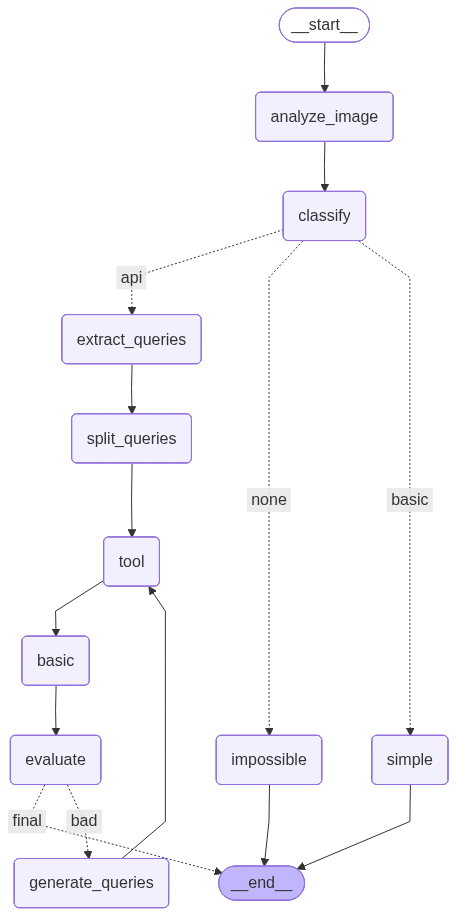

In [3]:
from utils.langgraph_setting2 import graph_setting

graph = graph_setting()

graph

In [4]:
response = run_langraph('안녕', 1, None)
print(response)

run_langraph 호출 - 입력: 안녕, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
일상 질문 답변 노드 시작
{'question': '안녕', 'answer': '안녕! 어떻게 도와줄까요?', 'messages': [], 'image': None, 'classify': 'basic', 'retry': False}


In [5]:
## 환경설정
!pip install -qU ragas langchain langchain-community langchain-openai langchain-chroma langchain-text-splitters pypdf rapidfuzz langgraph gdown chromadb langchain-huggingface sentence-transformers -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.18.0 requires aiofiles<24.0,>=22.0, but you have aiofiles 24.1.0 which is incompatible.
gradio 5.18.0 requires gradio-client==1.7.2, but you have gradio-client 1.10.1 which is incompatible.
gradio 5.18.0 requires markupsafe~=2.0, but you have markupsafe 3.0.2 which is incompatible.
langchain-pinecone 0.2.8 requires langchain-core<1.0.0,>=0.3.34, but you have langchain-core 1.0.5 which is incompatible.
langchain-tavily 0.2.11 requires langchain<0.4.0,>=0.3.20, but you have langchain 1.0.7 which is incompatible.
langchain-tavily 0.2.11 requires langchain-core<0.4.0,>=0.3.15, but you have langchain-core 1.0.5 which is incompatible.
langchain-tests 0.3.20 requires langchain-core<1.0.0,>=0.3.63, but you have langchain-core 1.0.5 which is incompatible.


In [6]:
import os
from dotenv import load_dotenv

load_dotenv()
# 필요한 라이브러리 임포트
import os
import pandas as pd
from pprint import pprint
# LangChain 관련 라이브러리
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# RAGAS 관련 라이브러리
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.persona import Persona
from ragas.testset import TestsetGenerator
from ragas import EvaluationDataset, evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

## 아래와 같은 형식으로 정답 데이터 셋 만들어야 함.

In [7]:
import pandas as pd

# 같은 폴더(현재 작업 디렉토리)에 저장했다면
dataset_df = pd.read_csv("./data/dataset2.csv")
print(dataset_df.shape)
display(dataset_df)

(20, 4)


,user_input,reference_contexts,reference,synthesizer_name
0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,['Q: S/MIME 인증서를 관리하기 위해 CSV 파일을 처리하는 함수에서 어떤 ...,"CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되...",single_hop_specific_query_synthesizer
1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,['Q: Cloud Firestore의 부하 분산 기능은 어떻게 작동하나요?\nA:...,Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 ...,single_hop_specific_query_synthesizer
2,범위 많으면 동의 어렵나요?,['Q: OAuth 2.0을 사용할 때 요청하는 범위의 수가 사용자 동의에 미치는 ...,요청된 범위 수가 많으면 사용자 동의를 얻을 가능성이 낮아질 수 있습니다.,single_hop_specific_query_synthesizer
3,As a beginner who is not familiar with Google ...,"['Q: Google Cloud 세션 제어 기능이란 무엇이며, 어떤 영향을 미치나요...",When Google Cloud session control features are...,single_hop_specific_query_synthesizer
4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Fire...",['Q: Cloud Firestore에서 특정 문서의 모든 변경에 대해 이벤트를 트...,Cloud Firestore에서 특정 문서의 모든 변경에 이벤트를 트리거하려면 on...,single_hop_specific_query_synthesizer
5,Firebase에서 다단계 인증(MFA)을 사용할 때 Objective-C로 사용자...,['Q: 다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료하는 ...,다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료하는 방법은 F...,single_hop_specific_query_synthesizer
6,Java를 사용해서 Firestore에 문서를 추가할 때 어떤 코드를 사용하나요?,['Q: Firestore에서 문서에 데이터를 추가할 때 사용하는 Java 코드 예...,다음은 Java에서 Firestore에 문서를 추가할 때 사용하는 코드 예시입니다....,single_hop_specific_query_synthesizer
7,COLUMNS가 Dimension API에서 무슨 뜻인가요?,['Q: Dimension API에서 사용할 수 있는 열거형 값은 무엇인가요?\nA...,COLUMNS는 Dimension API에서 시트의 열에서 작동함을 의미합니다.,single_hop_specific_query_synthesizer
8,ttll이 뭐에요? 그리고 한도 같은거 있나요?,['Q: TTL 정책을 적용할 때 한도 및 제약조건은 무엇인가요?\nA: 컬렉션 그...,"컬렉션 그룹당 하나의 필드만 TTL 필드로 표시할 수 있고, 필드 수준 구성은 최대...",single_hop_specific_query_synthesizer
9,Me want know what FUNCTION_ENTRYPOINT do in gc...,['Q: gcloud CLI를 사용하여 Cloud Run 함수를 배포한 후 트리거를...,FUNCTION_ENTRYPOINT는 gcloud run deploy 명령어에서 함...,single_hop_specific_query_synthesizer


### RAG 체인 구성 및 평가 데이터셋 생성

In [10]:

## 02.RAG 체인 구성

import pandas as pd
from datasets import Dataset
import uuid
import time


evaluated_dataset = []

# --- 시간 측정 (evaluate만) ---
start_time = time.perf_counter()

for _, row in dataset_df.iterrows():
    time.sleep(1)
    query = row.user_input  # 사용자 입력 - 합성 데이터셋에서 가져옴

    # run_langraph 함수 호출
    rag_result = run_langraph(query,'1', None)

    evaluated_dataset.append(
        {
            "user_input": query,
            "retrieved_contexts": rag_result["search_results_final"],
            "response": rag_result["answer"],
            "reference": row['reference']
        }
    )

end_time = time.perf_counter()

elapsed = end_time - start_time

# 시간 포맷팅
minutes = int(elapsed // 60)
seconds = elapsed % 60

print(f"RAG 응답 전체 소요 시간: {minutes}분 {seconds:.2f}초")

print("평가 데이터셋 준비 완료")

# RAGAS 평가 데이터셋 생성
ragas_evaluated_dataset = Dataset.from_list(evaluated_dataset)
# csv 데이터 저장
ragas_evaluated_dataset.to_pandas().to_csv('ragas_evaluated_dataset_post1.csv', index=False)
ragas_evaluated_dataset.to_pandas().info()

run_langraph 호출 - 입력: CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
[tool_based_search_node] 실행 - queries=['CSV 파일을 사용하여 S/MIME 인증서를 관리하는 방법은 무엇인가요?', 'How can I manage S/MIME certificates using a CSV file?']
[vector_search_tool] hybrid 검색 완료: 'CSV 파일을 사용하여 S/MIME 인증서를 관리하는 방법은 무엇인가요?', tags=['gmail']
[vector_search_tool] hybrid 검색 완료: 'How can I manage S/MIME certificates using a CSV file?', tags=['gmail']
[basic_langgraph_node] 생성된 답변: CSV 파일을 이용하여 S/MIME 인증서를 관리하려면 다음과 같은 작업이 필요합니다:

1. **CSV 파일 준비**: CSV 파일에는 각 행에 사용자 ID, 인증서 경로, 인증서 비밀번호가 포함되어야 합니다. 예를 들어:
   ```
   user1@example.com,/path/to/user1_cert.p12,cert_password_1
   user2@example.com,/path/to/user2_cert.p12,cert_password_2
   user3@example.com,/path/to/user3_cert.p12,cert_password_3
   ```

2. **CSV 파일 처리 함수 사용**: Python에서는 `insert_cert_from_csv` 함수를 사용하여 CSV 파일을 처리할 수 있습니다. 이 함수는 CSV 파일을 열고 각 행을 읽어 사용자 ID, 인증서 경로, 인증서 비밀번호를 추출합니다. 그런 다음 `create_smime_info`와 `insert_smime_info

In [11]:
import time

# LLM 래퍼 생성
evaluator_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
evaluator_llm = LangchainLLMWrapper(evaluator_llm)

# 평가 메트릭 정의
metrics = [
    LLMContextRecall(),
    Faithfulness(),
    FactualCorrectness()
]

# --- 시간 측정 (evaluate만) ---
start_time = time.perf_counter()

result = evaluate(
    dataset=ragas_evaluated_dataset,
    metrics=metrics,
    llm=evaluator_llm,
)

print('RAGAS 평가 완료!')

# ------------------------------

print('평가 결과:', result)
# 결과를 DataFrame으로 변환
result_df = result.to_pandas()

# 결과 저장
result_df.to_csv('ragas_evaluation_result_post1.csv', index=False)

display(result_df.head())
result_df[['context_recall', 'faithfulness', 'factual_correctness(mode=f1)']].describe()

C:\Users\miny0\AppData\Local\Temp\ipykernel_24532\1409261177.py:5: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LangchainLLMWrapper(evaluator_llm)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

RAGAS 평가 완료!
평가 결과: {'context_recall': 0.8500, 'faithfulness': 0.8457, 'factual_correctness(mode=f1)': 0.5235}


,user_input,retrieved_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1)
0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,"[except (OSError, IOError) as error:\n prin...",CSV 파일을 이용하여 S/MIME 인증서를 관리하려면 다음과 같은 작업이 필요합니...,"CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되...",1.0,1.000000,0.22
1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,[Cloud Firestore의 분할은 필요할 때 또는 키 공간이 확장될 때 더 많...,Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 ...,Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 ...,1.0,1.000000,0.80
2,범위 많으면 동의 어렵나요?,[Cloud Firestore의 분할은 필요할 때 또는 키 공간이 확장될 때 더 많...,"""범위 많으면 동의 어렵나요?""는 제가 모르는 내용입니다. 일상 질문 혹은 구글 A...",요청된 범위 수가 많으면 사용자 동의를 얻을 가능성이 낮아질 수 있습니다.,0.0,0.000000,0.00
3,As a beginner who is not familiar with Google ...,[또한 사용자 계정 또는 서비스 계정이 모든 클라이언트에서 보유할 수 있는 총 새로...,When Google Cloud session control features are...,When Google Cloud session control features are...,1.0,1.000000,0.61
4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Fire...",[Cloud Functions로 Firestore 확장\n\nbookmark_bor...,Cloud Firestore에서 문서가 변경될 때마다 자동으로 실행되는 함수를 작성...,Cloud Firestore에서 특정 문서의 모든 변경에 이벤트를 트리거하려면 on...,1.0,0.947368,0.67


,context_recall,faithfulness,factual_correctness(mode=f1)
count,20.000000,20.000000,20.000000
mean,0.850000,0.845702,0.523500
std,0.328473,0.318526,0.318983
min,0.000000,0.000000,0.000000
25%,1.000000,0.910526,0.272500
50%,1.000000,1.000000,0.640000
75%,1.000000,1.000000,0.710000
max,1.000000,1.000000,1.000000


In [12]:
display(result_df)

,user_input,retrieved_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1)
0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,"[except (OSError, IOError) as error:\n prin...",CSV 파일을 이용하여 S/MIME 인증서를 관리하려면 다음과 같은 작업이 필요합니...,"CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되...",1.0,1.000000,0.22
1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,[Cloud Firestore의 분할은 필요할 때 또는 키 공간이 확장될 때 더 많...,Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 ...,Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 ...,1.0,1.000000,0.80
2,범위 많으면 동의 어렵나요?,[Cloud Firestore의 분할은 필요할 때 또는 키 공간이 확장될 때 더 많...,"""범위 많으면 동의 어렵나요?""는 제가 모르는 내용입니다. 일상 질문 혹은 구글 A...",요청된 범위 수가 많으면 사용자 동의를 얻을 가능성이 낮아질 수 있습니다.,0.0,0.000000,0.00
3,As a beginner who is not familiar with Google ...,[또한 사용자 계정 또는 서비스 계정이 모든 클라이언트에서 보유할 수 있는 총 새로...,When Google Cloud session control features are...,When Google Cloud session control features are...,1.0,1.000000,0.61
4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Fire...",[Cloud Functions로 Firestore 확장\n\nbookmark_bor...,Cloud Firestore에서 문서가 변경될 때마다 자동으로 실행되는 함수를 작성...,Cloud Firestore에서 특정 문서의 모든 변경에 이벤트를 트리거하려면 on...,1.0,0.947368,0.67
5,Firebase에서 다단계 인증(MFA)을 사용할 때 Objective-C로 사용자...,[Firebase Authentication with Identity Platfor...,Objective-C에서 다단계 인증(MFA) 사용자를 인증하는 방법은 다음과 같습...,다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료하는 방법은 F...,1.0,1.000000,0.74
6,Java를 사용해서 Firestore에 문서를 추가할 때 어떤 코드를 사용하나요?,[Firestore는 컬렉션에 저장되는 문서에 데이터를 저장합니다.\n문서에 데이터...,Java를 사용해서 Firestore에 문서를 추가할 때는 다음과 같은 코드를 사용...,다음은 Java에서 Firestore에 문서를 추가할 때 사용하는 코드 예시입니다....,0.5,1.000000,0.10
7,COLUMNS가 Dimension API에서 무슨 뜻인가요?,[COLUMN_NAME: 임베딩 데이터가 포함된 열의 이름입니다. 이 열은 ARRA...,"Dimension API에서 ""COLUMNS""는 시트의 열에서 작동하는 것을 의미합...",COLUMNS는 Dimension API에서 시트의 열에서 작동함을 의미합니다.,1.0,1.000000,1.00
8,ttll이 뭐에요? 그리고 한도 같은거 있나요?,[COLUMN_NAME: 임베딩 데이터가 포함된 열의 이름입니다. 이 열은 ARRA...,"""ttll이 뭐에요? 그리고 한도 같은거 있나요?""는 제가 모르는 내용입니다. 일상...","컬렉션 그룹당 하나의 필드만 TTL 필드로 표시할 수 있고, 필드 수준 구성은 최대...",0.0,0.000000,0.00
9,Me want know what FUNCTION_ENTRYPOINT do in gc...,[--- 탭: gcloud [https://cloud.google.com/fires...,"In the `gcloud run deploy` command, the `FUNCT...",FUNCTION_ENTRYPOINT는 gcloud run deploy 명령어에서 함...,1.0,1.000000,0.50
